# Model 1: Baseline 

This model will be built using **only** beatAML data to predict AUC. 




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle
from torch.utils import data
from matplotlib import pyplot as plt
import pandas as pd
import imageio

# Utilities 

In [80]:
# plot and show learning process
#from : https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379

def plot_learning_process(axes, tr_ys, tr_yhats, tst_ys, tst_yhats, epoch, tr_loss, tst_loss):

    axes[0].cla()
    
    ######### TRAIN #########
    tr_df = pd.DataFrame({'y':tr_ys, 'yhat':tr_yhats})
    tr_df.sort_values(by='y', inplace=True)
    
    axes[0].plot(tr_df.values[:,0], 'ro', label='true', alpha=0.5)
    axes[0].plot(tr_df.values[:,1], 'bo', label='predicted', alpha=0.5)
    #plt.legend()
    
    axes[0].set_title('Regression Analysis [Training Set]', fontsize=15)
    axes[0].set_xlabel('Sorted observations', fontsize=24)
    axes[0].set_ylabel('AUC', fontsize=24)

    axes[0].text(100, 30, 'Epoch = %d' % epoch, fontdict={'size': 24, 'color':  'red'})
    axes[0].text(100, 50, 'Loss = %.4f' % loss, fontdict={'size': 24, 'color':  'red'})

    ######### TEST #########
    
    axes[1].cla()
    
    tst_df = pd.DataFrame({'y':tst_ys, 'yhat':tst_yhats})
    tst_df.sort_values(by='y', inplace=True)
    
    axes[1].plot(tst_df.values[:,0], 'ro', label='true', alpha=0.5)
    axes[1].plot(tst_df.values[:,1], 'bo', label='predicted', alpha=0.5)
    plt.legend()
    
    axes[1].set_title('Regression Analysis [Validation Set]', fontsize=15)
    axes[1].set_xlabel('Sorted observations', fontsize=24)
    axes[1].set_ylabel('AUC', fontsize=24)

    axes[1].text(100, 30, 'Epoch = %d' % epoch, fontdict={'size': 24, 'color':  'red'})
    axes[1].text(100, 50, 'Loss = %.4f' % loss, fontdict={'size': 24, 'color':  'red'})

    ######## DA REST #############
    
    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

class saver_and_early_stopping: 
    '''
    '''
    def __init__(self, max_epoch, lr, do, arch, wd, name='FCNN-AML', early_stop_patience = 10, save_path='../data_pytorch/'):
        ''''''
        self.lr = lr
        self.do = do
        self.arch = arch
        self.wd = wd 
        self.name = name 
        self.loss = np.inf 
        self.ii = 0
        self.patience = early_stop_patience
        self.max_epoch = max_epoch
        
        if not os.path.exists(save_path + 'model_' + name):
            os.mkdir(save_path + 'model_' + name)
            
        self.fpath = save_path + 'model_' + name
        
    def update(self, loss, epoch, model):
        '''
        '''
        if epoch == (self.max_epoch - 1):
            torch.save(model.state_dict(), self.fpath + f'/loss={self.loss:.2f}_epoch={epoch}_lr={self.lr}_do={self.do}_arch={self.arch}_wd={self.wd}.pt')
            self.fname = self.fpath + f'/loss={self.loss}_epoch={epoch}_lr={self.lr}_do={self.do}_arch={self.arch}_wd={self.wd}'
            return True
        if self.ii > self.patience: 
            torch.save(model.state_dict(), self.fpath + f'/loss={self.loss:.2f}_epoch={epoch}_lr={self.lr}_do={self.do}_arch={self.arch}_wd={self.wd}.pt')
            self.fname = self.fpath + f'/loss={self.loss}_epoch={epoch}_lr={self.lr}_do={self.do}_arch={self.arch}_wd={self.wd}'
            return False
        if loss < self.loss: 
            self.loss = loss 
            self.ii = 0
        else:
            self.ii += 1
        return True
    
    def get_fname(self): 
        ''''''
        return self.fname

# Define our Dataset Class 

In [81]:
class DrugExpressionDataset(Dataset): 
    '''
    '''
    def __init__ (self, label_dict, root_dir='../data_pytorch/tensors'): 
        '''
        '''
        self.index = list(label_dict.keys())
        self.labels = label_dict
        self.root = root_dir
                            
    def __len__(self):
        '''
        '''
        return len(self.labels.keys())
        
    def __getitem__(self, index, response_type=False):
        '''
        '''
        fid = self.index[index]
        X = torch.load(f'{self.root}/{fid}.pt') #<----------------------------- number of genes to use
        _id, id_type, resp_type, response = self.labels[fid]
        
        if response_type: 
            return X, (response, resp_type)
        else: 
            return X, response

# Separate data into train/test/validate 

In [82]:
train, test, val = (0.65,0.2,0.15)

with open('../data_pytorch/label_dict.pkl', 'rb') as f: 
    label_dict = pickle.load(f)

label_dict2 = dict()
for fid in label_dict: 
    _id, id_type, resp_type, response = label_dict[fid]
    
    if resp_type not in label_dict2: 
        label_dict2[resp_type] = dict()
        
    p = np.random.rand()
    if (p < train): # add to training set 
        if 'train' in label_dict2[resp_type]: 
            label_dict2[resp_type]['train'][fid] = (_id, id_type, resp_type, response)
        else:
            label_dict2[resp_type]['train'] = {fid:(_id, id_type, resp_type, response)}

    elif (p < train+test): # add to test set 
        if 'test' in label_dict2[resp_type]: 
            label_dict2[resp_type]['test'][fid] = (_id, id_type, resp_type, response)
        else:
            label_dict2[resp_type]['test'] = {fid:(_id, id_type, resp_type, response)}
    else: # add to validation set 
        if 'val' in label_dict2[resp_type]: 
            label_dict2[resp_type]['val'][fid] = (_id, id_type, resp_type, response)
        else:
            label_dict2[resp_type]['val'] = {fid:(_id, id_type, resp_type, response)}            

In [83]:
label_dict2.keys()

dict_keys(['RNAi_dependency', 'crispr_dependency', 'pooled_drugresp_prism', 'AUC_GDSC', 'CTRP_AUC', 'AUC_drug_CCLE', 'beatAML_AUC'])

In [84]:
for resp_type in label_dict2:
    for sset in label_dict2[resp_type]: 
        pp = resp_type + ' '*(20 - len(resp_type))
        print(f'set sizes: {pp} \t-> {sset}  \t-> {len(label_dict2[resp_type][sset])}')

set sizes: RNAi_dependency      	-> test  	-> 57208
set sizes: RNAi_dependency      	-> train  	-> 186480
set sizes: RNAi_dependency      	-> val  	-> 42851
set sizes: crispr_dependency    	-> train  	-> 202124
set sizes: crispr_dependency    	-> val  	-> 46594
set sizes: crispr_dependency    	-> test  	-> 62250
set sizes: pooled_drugresp_prism 	-> train  	-> 98993
set sizes: pooled_drugresp_prism 	-> test  	-> 30535
set sizes: pooled_drugresp_prism 	-> val  	-> 22899
set sizes: AUC_GDSC             	-> train  	-> 10824
set sizes: AUC_GDSC             	-> test  	-> 3333
set sizes: AUC_GDSC             	-> val  	-> 2507
set sizes: CTRP_AUC             	-> train  	-> 17995
set sizes: CTRP_AUC             	-> test  	-> 5497
set sizes: CTRP_AUC             	-> val  	-> 4138
set sizes: AUC_drug_CCLE        	-> val  	-> 339
set sizes: AUC_drug_CCLE        	-> test  	-> 471
set sizes: AUC_drug_CCLE        	-> train  	-> 1473
set sizes: beatAML_AUC          	-> train  	-> 1122
set sizes: beatA

In [85]:
max(label_dict.keys())

798259

# Defining our model architecture 

Going to use a straight forward 4 layer FFFC network. 

In [86]:
class Net(nn.Module):

    def __init__(self, ngenes, sz=(250,100,10), do=0.3, nconvs = 5):
        super(Net, self).__init__()
        
        H1, H2, H3 = sz
        
        self.layer1 = nn.Sequential(nn.Conv2d(1, nconvs, kernel_size=(1,2), stride=1, padding=0),
                                   nn.ReLU())
        
        self.do1 = torch.nn.Dropout(do)
        self.fc1 = nn.Linear(ngenes*nconvs, H1)
        self.bn1 = nn.BatchNorm1d(H1)
        self.do2 = torch.nn.Dropout(do)
        self.fc2 = nn.Linear(H1, H2)
        self.bn2 = nn.BatchNorm1d(H2)
        self.do3 = torch.nn.Dropout(do)
        self.fc3 = nn.Linear(H2, H3)
        self.bn3 = nn.BatchNorm1d(H3)
        self.out = nn.Linear(H3, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        z0 = self.layer1(x)
        z0 = z0.reshape(z0.size(0), -1)
        
        z1 = self.fc1( z0 )
        z1 = self.do1( z1 )
        z1 = self.bn1( z1 )
        a1 = F.relu( z1 )
        
        z2 = self.do2( self.fc2(a1) )
        z2 = self.bn2( z2 )
        a2 = F.relu(z2)
        
        z3 = self.do3( self.fc3(a2) )
        z3 = self.bn3( z3 )
        a3 = F.relu(z3)
        
        o = self.out(a3)
        
        return o

In [87]:
'''
class Net(nn.Module):

    def __init__(self, ngenes, sz=(250,100,10), do=0.3, nconvs = 5):
        super(Net, self).__init__()
        
        H1, H2, H3 = sz
      
        self.fc1 = nn.Linear(ngenes*2, H1)
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, H3)
        self.out = nn.Linear(H3, 1)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        
        z1 = self.fc1( x )
        a1 = F.leaky_relu( z1 )
        
        z2 = self.fc2(a1) 
        a2 = F.leaky_relu(z2)
        
        z3 = self.fc3(a2) 
        a3 = F.leaky_relu(z3)
        
        o = self.out(a3)
        
        return o
'''

'\nclass Net(nn.Module):\n\n    def __init__(self, ngenes, sz=(250,100,10), do=0.3, nconvs = 5):\n        super(Net, self).__init__()\n        \n        H1, H2, H3 = sz\n      \n        self.fc1 = nn.Linear(ngenes*2, H1)\n        self.fc2 = nn.Linear(H1, H2)\n        self.fc3 = nn.Linear(H2, H3)\n        self.out = nn.Linear(H3, 1)\n\n    def forward(self, x):\n        x = x.reshape(x.size(0), -1)\n        \n        z1 = self.fc1( x )\n        a1 = F.leaky_relu( z1 )\n        \n        z2 = self.fc2(a1) \n        a2 = F.leaky_relu(z2)\n        \n        z3 = self.fc3(a2) \n        a3 = F.leaky_relu(z3)\n        \n        o = self.out(a3)\n        \n        return o\n'

# Initialize our model and DataLoader(s)

In [118]:
LEARNING_WEIGHT = 1e-2
EPOCHS = 250
DROP_OUT_PROP = 0.05
LAYER_SIZE= (1200, 1100, 600) 
NCONVS = 2
WEIGHT_DECAY = 0.05
NGENES = 523 #/523
# Reproducibility
#torch.manual_seed(2)
#np.random.seed(2)

In [119]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [120]:
net = Net(ngenes = NGENES, sz=LAYER_SIZE, do=DROP_OUT_PROP, nconvs=NCONVS)
print(net)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(1, 2), stride=(1, 1))
    (1): ReLU()
  )
  (do1): Dropout(p=0.05, inplace=False)
  (fc1): Linear(in_features=1046, out_features=1200, bias=True)
  (bn1): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do2): Dropout(p=0.05, inplace=False)
  (fc2): Linear(in_features=1200, out_features=1100, bias=True)
  (bn2): BatchNorm1d(1100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do3): Dropout(p=0.05, inplace=False)
  (fc3): Linear(in_features=1100, out_features=600, bias=True)
  (bn3): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=600, out_features=1, bias=True)
)


In [121]:
# Parameters
params = {'batch_size': 128*3,
          'shuffle': True,
          'num_workers': 0}

train_set = DrugExpressionDataset(label_dict2['beatAML_AUC']['train'])
test_set = DrugExpressionDataset(label_dict2['beatAML_AUC']['test'])
val_set = DrugExpressionDataset(label_dict2['beatAML_AUC']['val'])

train_gen = data.DataLoader(train_set, **params)
test_gen = data.DataLoader(test_set, **params)
val_gen = data.DataLoader(val_set, **params)

In [122]:
optim = torch.optim.Adam(net.parameters(recurse=True), lr=LEARNING_WEIGHT, weight_decay=WEIGHT_DECAY)
loss_func = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=7, verbose=False, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)  #torch.optim.lr_scheduler.MultiStepLR(optim, milestones=DECAY_MILESTONES, gamma=GAMMA)

# Train our model

epoch 75/250 	|	 train total loss: 1802.70 	 train mse: 1.61 	|	 val mse: 11.54 						
stopping early due to lack of loss improvement...
final epoch: 74


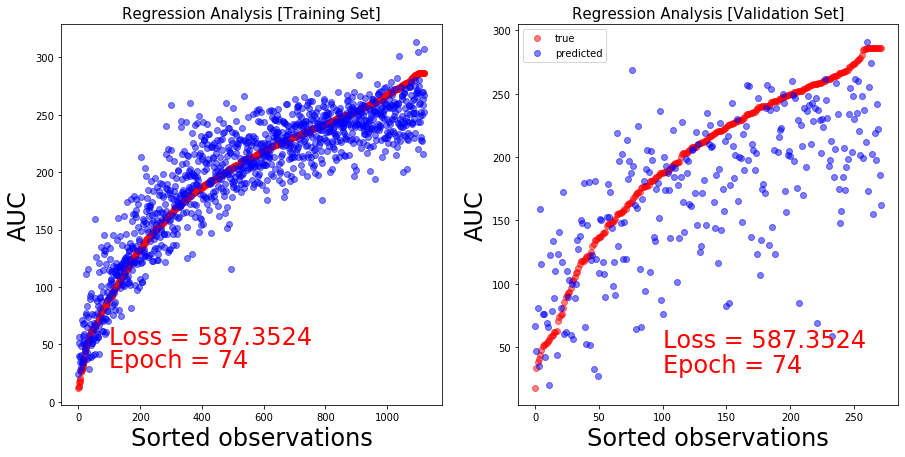

In [123]:
recorder={'train':{'total_loss':[], 'mse':[]}, 'val':{'mse':[]}}
images = []
fig, ax = plt.subplots(1,2,figsize=(15,7))
saver = saver_and_early_stopping(max_epoch=EPOCHS, lr=LEARNING_WEIGHT, do=DROP_OUT_PROP, arch=LAYER_SIZE, wd=WEIGHT_DECAY, name='FCNN-AML', early_stop_patience = 15, save_path='../data_pytorch/')

for epoch in range(EPOCHS):
    net.train()
    total_loss = 0
    mse = 0
    yhats=[]
    ys=[]
    for X,y in train_gen:
        y = y.unsqueeze(1)
        X,y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
        yhat = net(X)
        loss = loss_func(yhat, y)
        optim.zero_grad()
        loss.backward()
        optim.step() 
        scheduler.step(loss)
        total_loss += loss.detach().numpy()
        yhats += yhat.data.numpy().ravel().tolist()
        ys += y.data.numpy().ravel().tolist()
        
    recorder['train']['total_loss'].append(total_loss)
    recorder['train']['mse'].append(total_loss/len(train_gen.dataset))

    val_total_loss = 0
    val_yhats=[]
    val_ys=[]
    net.eval()
    with torch.set_grad_enabled(False):
        for X, y in val_gen:
            X,y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
            y = y.unsqueeze(1)
            yhat = net(X)
            val_total_loss += loss_func(yhat, y).data.numpy()
            val_yhats += yhat.data.numpy().ravel().tolist()
            val_ys += y.data.numpy().ravel().tolist()
        recorder['val']['mse'].append(val_total_loss / len(val_gen.dataset))
    
    images.append( plot_learning_process(axes=ax, tr_ys=ys , tr_yhats=yhats, tst_ys = val_ys, tst_yhats = val_yhats, epoch=epoch, tr_loss=total_loss/len(train_gen.dataset), tst_loss=val_total_loss / len(val_gen.dataset)) )
    print(f'epoch {epoch+1}/{EPOCHS} \t|\t train total loss: {total_loss:.2f} \t train mse: {total_loss/len(train_gen.dataset):.2f} \t|\t val mse: {val_total_loss / len(val_gen.dataset):.2f} \t\t\t', end='\r')
    if (not saver.update(total_loss, epoch, net)):
        print()
        print('stopping early due to lack of loss improvement...')
        print(f'final epoch: {epoch}')
        break
      
imageio.mimsave(f'{saver.get_fname()}_training.gif', images, fps=10)

### visualize training 

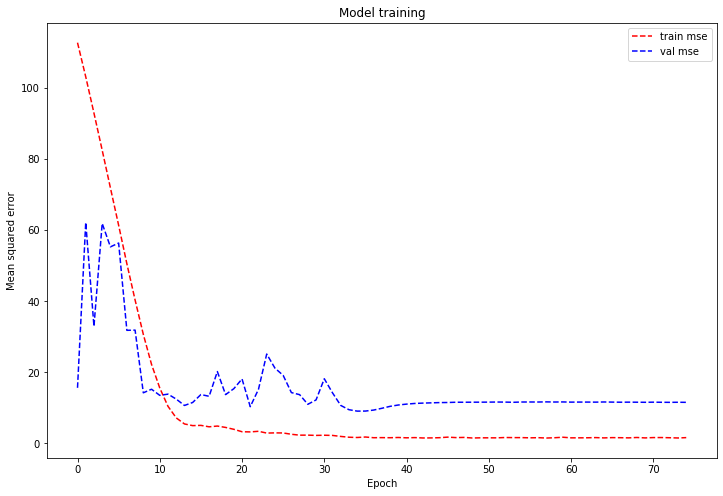

In [124]:
plt.figure(figsize=(12,8))
plt.plot(recorder['train']['mse'], 'r--', label='train mse')
plt.plot(recorder['val']['mse'], 'b--', label='val mse')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.title('Model training')
plt.legend()
plt.show()

# Test our model

In [144]:
net.eval()
test_total_loss = 0
yhats = []
ys = []
for X, y in test_gen:
    X,y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
    y = y.unsqueeze(1)
    yhat = net.forward(X)
    test_total_loss += loss_func(yhat, y).detach().numpy()
    yhats += yhat.data.numpy().ravel().tolist()
    ys += y.data.numpy().ravel().tolist()

net.train()

print(f'test mse: {test_total_loss/len(test_gen.dataset)}')

test mse: 6.776726865096831


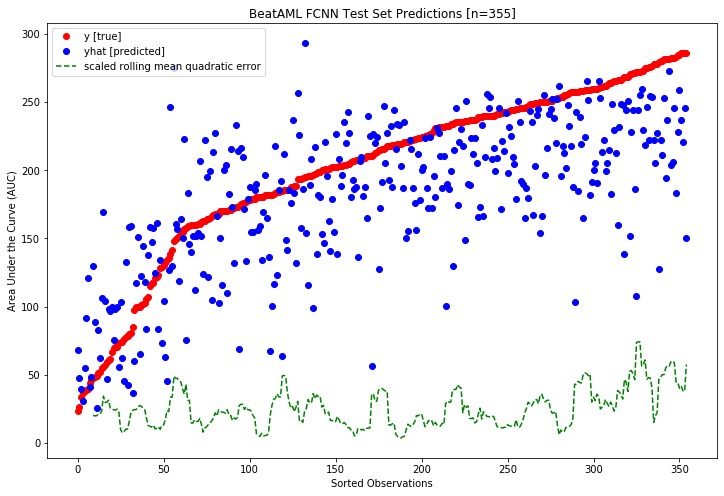

In [145]:
df = pd.DataFrame({'y':ys, 'yhat':yhats}).assign(diff = lambda x: np.max(x.y) * (x.y-x.yhat)**2 / np.max((x.y-x.yhat)**2))

df.sort_values(by='y', inplace=True)

df = df.assign(diff_rm = df['diff'].rolling(window=10).mean())

plt.figure(figsize=(12,8))
plt.plot(df['y'].values, 'ro', label='y [true]')
plt.plot(df['yhat'].values, 'bo', label='yhat [predicted]')
plt.plot(df['diff_rm'].values, 'g--', label='scaled rolling mean quadratic error')
plt.xlabel('Sorted Observations')
plt.ylabel('Area Under the Curve (AUC)')
plt.title(f'BeatAML FCNN Test Set Predictions [n={len(test_gen.dataset)}]')
plt.legend()
plt.show()
